# Solution 3.3

## DRW & UofC Quant Foundations
### Summer 2023
#### Mark Hendricks
#### hendricks@uchicago.edu

# Penalized Regression

$$\newcommand{\nsecs}{451}$$
$$\newcommand{\target}{GLD}$$
$$\newcommand{\spy}{\text{spy}}$$
$$\newcommand{\hyg}{\text{hyg}}$$

## Data
* This homework uses the file, `data/hw_3_3_data.xlsx`.
* Find the data in the Github repo associated with the module, (link on Canvas.)

The data file contains...
* Return rates, $r^{\target}_t$, for the \target, (an ETF,) which tracks the returns on gold.
* Return rates, $r^i_t$, for $\nsecs$ single-name equities.\footnote{These are all securities in the S\&P 500 as of June 2022, filtered for names with sufficient return histories.}

## Model
Consider a regression of $\target$, denoted $r^{\target}$, on all $\nsecs$ returns of the S&P 500 stocks.

$$
r^{\target}_t = \alpha + \sum_{j=1}^k \beta^j r^j_t + \epsilon_t
\label{eq:REG}
$$

We refer to this equation below as the `MODEL`.

# 1. 

Estimate the `MODEL` with OLS.

#### Note
For this OLS estimation, along with the estimations below, try using scikit-learn in Python

`from sklearn import LinearRegression Lasso Ridge`

For OLS specifically, try

`model\_ols = LinearRegression().fit(X,y)`

### 1.1. 
Report the estimated intercept and betas. 
### 1.2. 
Report the R-squared.
### 1.3. 
Which factors have the largest betas in explaining $r^{\target}$?
### 1.4. 
Calculate $\beta^j \sigma^j$ for each regressor. Which of these is largest in magnitude, and thus most influential in explaining $r^{\target}$?

#### Note
The beta being large may simply be because the regressor volatility is small. By scaling by the volatility, we get a better idea of which regressor is driving the most variation.

### 1.5. 
Report the matrix condition number of $R'R$, where $R$ denotes the matrix of single-name equity return data. Why should this condition number give us pause about trusting the OLS estimates out-of-sample?

#### Note
To get the matrix condition number, consider using, in Python, `numpy.linalg.cond()`.

# <span style='color:red'>Solution 1</span>

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rets_sp500 = pd.read_excel('../data/hw_3_3_data.xlsx', sheet_name=2, index_col=0)
rets_gld = pd.read_excel('../data/hw_3_3_data.xlsx', sheet_name=3, index_col=0)[['GLD']]

## <span style='color:red'>1.1</span>

In [3]:
ols_model = sm.OLS(rets_gld, sm.add_constant(rets_sp500)).fit()

# Coefficients
coef_ols = ols_model.params[1:].to_frame('Beta')
coef_ols

,Beta
A,0.065344
AAP,-0.030014
AAPL,-0.089102
ABC,-0.042315
ABT,0.075335
...,...
XYL,0.028848
YUM,-0.011571
ZBH,0.005700
ZBRA,0.054676


## <span style='color:red'>1.2</span>

In [4]:
# R-Squared
ols_model.rsquared

1.0

## <span style='color:red'>1.3</span>

In [5]:
ols_model.params.loc[lambda x: x.abs().nlargest(5).index]

NEM     0.159891
XOM    -0.152576
PM      0.134019
USB     0.132334
MSFT   -0.132020
dtype: float64

## <span style='color:red'>1.4</span>

In [6]:
sigma_beta_ols = rets_sp500.std() * coef_ols['Beta']

sigma_beta_ols.loc[lambda x: x.abs().nlargest(5).index]

NEM    0.007798
UAL   -0.006702
XOM   -0.005969
PHM    0.005465
SPG    0.005242
dtype: float64

Scaling by $\sigma_j$ allows us to have a more useful comparison between regression coefficients. In doing so, we find the largest (in magnitude) of the coefficients, and thus the most influential regressor, is NEM. 

## <span style='color:red'>1.5</span>

In [7]:
# Excluding intercept
np.linalg.cond(rets_sp500.T @ rets_sp500)

6.1330286723879125e+19

## <span style='color:red'>1.6</span>

In [8]:
# Including intercept
np.linalg.cond(sm.add_constant(rets_sp500).T @ sm.add_constant(rets_sp500))

1.955335685452951e+20

A large condition number should give us pause as it indicates that very small change in the inputs to our training data would yield very large changes in our model's fitted parameters. In the case of linear regression, a high condition number raises concerns about multicollinearity, which can easily distort both the interpretation of coefficients and their out-of-sample performance. The condition numbers produced here are extremely large.

# 2. 

Estimate `MODEL` with Ridge Regression. 
* Use a penalty of 0.5 in the estimation.
* Try using `est = Ridge(alpha=0.5).fit(X,y)`

### 2.1.
Report the R-squared.
### 2.2.
Based on $\beta^j \sigma^j$, which factor is most influential for $r^{\target}$?

# <span style='color:red'>Solution 2</span>

## <span style='color:red'>2.1.</span>

In [9]:
model_Ridge = Ridge(alpha=0.5, fit_intercept=True).fit(rets_sp500, rets_gld)

coef_ridge = pd.DataFrame(data=model_Ridge.coef_.reshape(451), index=rets_sp500.columns, columns=['Beta'])
coef_ridge

,Beta
A,0.013014
AAP,-0.013048
AAPL,-0.005152
ABC,-0.005360
ABT,0.001704
...,...
XYL,0.004060
YUM,0.001713
ZBH,-0.005478
ZBRA,0.001794


In [10]:
model_Ridge.score(rets_sp500, rets_gld)

0.7622443309155419

## <span style='color:red'>2.2.</span>

In [11]:
sigma_beta_ridge = rets_sp500.std() * coef_ridge['Beta']

sigma_beta_ridge.loc[lambda x: x.abs().nlargest(5).index]

NEM     0.005137
FCX     0.002314
ENPH    0.002027
SCHW   -0.001656
RHI    -0.001149
dtype: float64

We find that NEM again seems to be most influential.

# 3. 

Estimate `MODEL` with LASSO Regression. 
* Use a penalty of 2e-5 in the estimation.
* Try using `est = Lasso(alpha=3e-4).fit(X,y)`

### 3.1.
Report the estimated intercept and betas. 
### 3.2.
Report the R-squared.
### 3.3.
Based on $\beta^j \sigma^j$, which factor is most influential for $r^{\target}$?
### 3.4.
How many regressors have a non-zero beta estimates? 

# <span style='color:red'>Solution 3</span>

## <span style='color:red'>3.1.</span>

In [12]:
model_Lasso = Lasso(alpha=2e-5, fit_intercept=True).fit(rets_sp500, rets_gld)

coef_lasso = pd.DataFrame(data=model_Lasso.coef_.reshape(451), index=rets_sp500.columns, columns=['Beta'])
coef_lasso

,Beta
A,0.011062
AAP,-0.001673
AAPL,-0.000000
ABC,-0.001622
ABT,0.000000
...,...
XYL,0.000000
YUM,-0.000000
ZBH,-0.000000
ZBRA,-0.000000


## <span style='color:red'>3.2.</span>

In [13]:
model_Lasso.score(rets_sp500, rets_gld)

0.7541466465557549

## <span style='color:red'>3.3.</span>

In [14]:
sigma_beta_lasso = rets_sp500.std() * coef_lasso['Beta']

sigma_beta_lasso.loc[lambda x: x.abs().nlargest(5).index]

NEM     0.011329
SCHW   -0.002511
O       0.002376
RJF    -0.002057
SLB     0.001808
dtype: float64

NEM is the largest coefficient, and is significantly larger than even the second largest coefficient.

## <span style='color:red'>3.4.</span>

In [15]:
(coef_lasso != 0).sum()[0]

75

# 4.

How do the estimations compare across the three methods?

### 4.1.
Create a histogram of estimated betas across the three methods, (OLS, Ridge, LASSO.) 

Are they all nonzero? Are there positive and negative values? Do they range widely in magnitude? 

### 4.2.
Which has the largest R-squared? Is this a surprise?

# <span style='color:red'>Solution 4</span>

## <span style='color:red'>4.1.</span>

<Axes: title={'center': 'OLS Coefficients'}, ylabel='Frequency'>

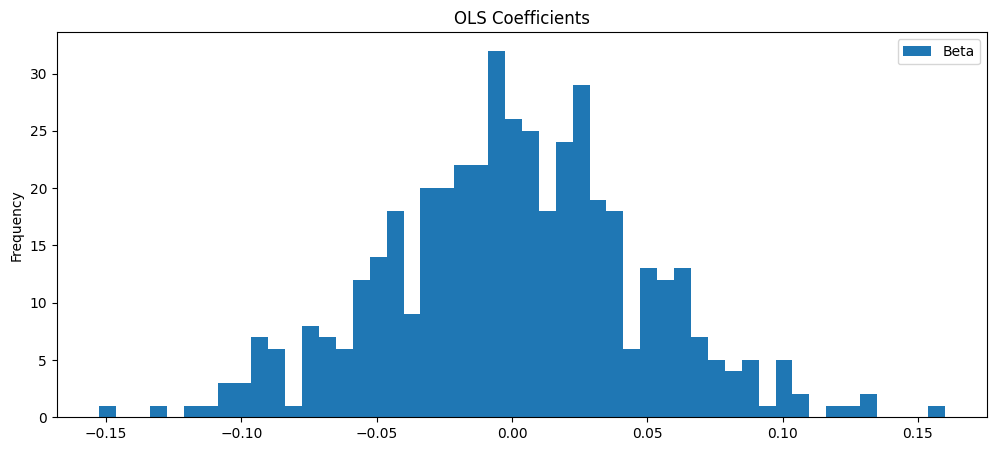

In [16]:
coef_ols.plot(kind='hist', bins=50, figsize=(12, 5), title='OLS Coefficients')

<Axes: title={'center': 'Ridge Coefficients'}, ylabel='Frequency'>

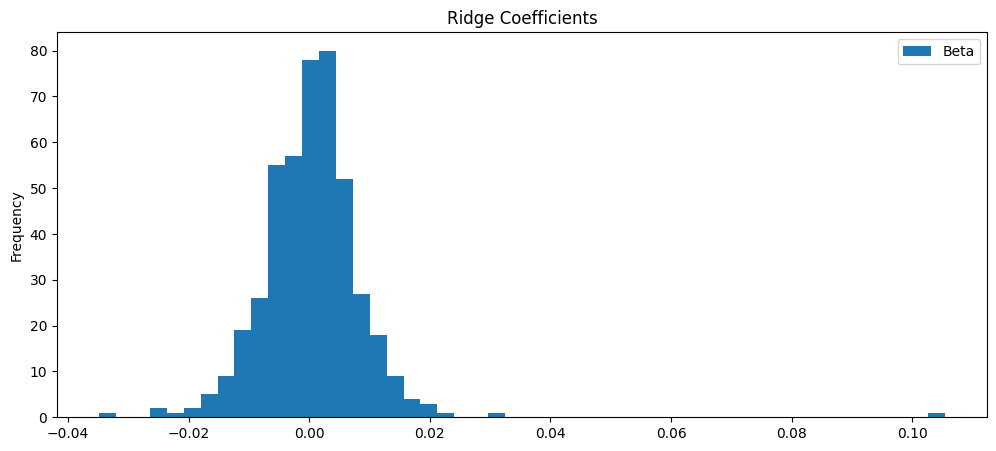

In [17]:
coef_ridge.plot(kind='hist', bins=50, figsize=(12, 5), title='Ridge Coefficients')

<Axes: title={'center': 'Lasso Coefficients'}, ylabel='Frequency'>

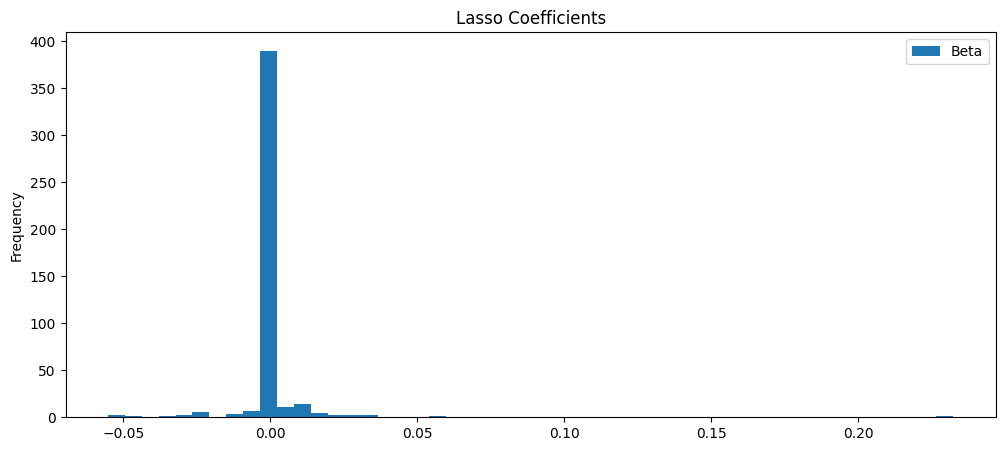

In [18]:
coef_lasso.plot(kind='hist', bins=50, figsize=(12, 5), title='Lasso Coefficients')

Immediately, it is quite clear that the penalized regressions (Lasso and Ridge) have notably smaller coefficients in general. It is also clear that the penalized regressions tend to push many coefficients towards 0, but some get pushed away from 0. This reflects the notion that the penalties serve to give more "responsibility" to certain regressors.

Unsurprisingly, all 3 models had coefficients distributed near 0, with Lasso having a significant proportion of them being equal to 0.

## <span style='color:red'>4.2.</span>

From above, we found that OLS had the largest r-squared, which is entirely unsurprising given that this is referring to *in sample* performance. OLS was given far more "power" to fit the training data.

## 5.

Try using cross-validation (with K-folds) to estimate the penalty parameter for Ridge and LASSO.

Estimate this CV using two functions from  `sklearn.linear_model`
* RidgeCV
* LassoCV

Feel free to use the default parameters, including the default number of folds.

Report the CV penalty parameter for Lasso and Ridge.

# <span style='color:red'>Solution 5</span>

In [19]:
model_ridge_cv = RidgeCV().fit(rets_sp500, np.ravel(rets_gld))

In [20]:
model_ridge_cv.alpha_

0.1

In [21]:
model_lasso_cv = LassoCV(max_iter=100).fit(rets_sp500, np.ravel(rets_gld))

/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.291e-05, tolerance: 9.567e-06
  model = cd_fast.enet_coordinate_descent(
/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.129e-05, tolerance: 9.567e-06
  model = cd_fast.enet_coordinate_descent(
/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the

/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.308e-04, tolerance: 9.567e-06
  model = cd_fast.enet_coordinate_descent(
/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e-04, tolerance: 9.567e-06
  model = cd_fast.enet_coordinate_descent(
/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the

/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.229e-04, tolerance: 1.118e-05
  model = cd_fast.enet_coordinate_descent(
/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.234e-04, tolerance: 1.118e-05
  model = cd_fast.enet_coordinate_descent(
/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the

/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.333e-04, tolerance: 1.118e-05
  model = cd_fast.enet_coordinate_descent(
/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.027e-04, tolerance: 1.118e-05
  model = cd_fast.enet_coordinate_descent(
/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the

/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.756e-04, tolerance: 1.127e-05
  model = cd_fast.enet_coordinate_descent(
/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.354e-04, tolerance: 1.127e-05
  model = cd_fast.enet_coordinate_descent(
/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the

/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e-05, tolerance: 7.604e-06
  model = cd_fast.enet_coordinate_descent(
/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.090e-05, tolerance: 7.604e-06
  model = cd_fast.enet_coordinate_descent(
/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the

/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.332e-04, tolerance: 7.604e-06
  model = cd_fast.enet_coordinate_descent(
/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.341e-04, tolerance: 7.604e-06
  model = cd_fast.enet_coordinate_descent(
/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the

/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.658e-04, tolerance: 1.038e-05
  model = cd_fast.enet_coordinate_descent(
/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.012e-04, tolerance: 1.038e-05
  model = cd_fast.enet_coordinate_descent(
/Users/markhendricks/Projects/drw-dataanalysis-2023/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the

In [22]:
model_lasso_cv.alpha_

4.555415661524658e-05

## 6.

Use your estimations based on data through 2020 to fit the model for 2021-2022. 

Use the CV penalty parameters (from the previous problem) for Ridge and Lasso.

What is the r-squared in these out-of-sample fits?

#### Note
Doing this is really easy in Python. For instance, for the LASSO estimation, you could try

`est = Lasso(alpha=3e-4).fit(X,y)`

`score_is = est.score(X_insamp,y_insamp)`

`score_oos = est.score(X_oos,y_oos)`

Which method does better out-of-sample?

# <span style='color:red'>Solution 6</span>

In [23]:
train_X = rets_sp500.loc[:'2020']
train_y = rets_gld.loc[:'2020']

test_X = rets_sp500.loc['2021':]
test_y = rets_gld.loc['2021':]

In [24]:
ols_is = LinearRegression().fit(train_X, train_y)
ridge_is = Ridge(alpha=model_ridge_cv.alpha_).fit(train_X, train_y)
lasso_is = Lasso(alpha=model_lasso_cv.alpha_).fit(train_X, train_y)

In [25]:
# OLS OOS R-Squared
ols_is.score(test_X, test_y)

-0.5375280801815447

In [26]:
# Ridge OOS R-Squared
ridge_is.score(test_X, test_y)

0.32405213124848276

In [27]:
# Lasso OOS R-Squared
lasso_is.score(test_X, test_y)

0.48784447997601943

As demonstrated by the out of sample r-squared values, OLS performs far worse than does penalized regression. In fact, both Lasso and Ridge perform far better than the null model. Given more penalty values in our cross-validation for Ridge (instead of the default scikit-learn parameters), we may be better able to compare Lasso and Ridge. In general, however, it is important to remember that the "optimal" penalties found in part 5 were calculated using the test sample, which gives rise to some lookahead bias.